In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import math
import matplotlib.pyplot as plt

### Análisis Exploratorio de los datos

In [5]:
data = pd.read_csv("pedidos por mesa.csv", encoding='latin1')
data.head()

,created_at,updated_at,id,deleted_at,is_active,qty,product_name,details,importe,qty_payed,total_price,command_id,product_id,is_deleted
0,9/23/2020 19:33,9/23/2020 19:33,665,NaN,1,1,Alemana,NaN,7.5,0,7.5,101,215,0
1,9/29/2020 20:24,9/29/2020 20:24,741,NaN,1,1,Heineken,NaN,3.0,0,3.0,128,159,0
2,10/2/2020 18:54,10/2/2020 18:54,901,NaN,1,2,Cerveza botella,NaN,6.0,0,6.0,150,16,0
3,10/4/2020 18:07,10/4/2020 18:07,902,NaN,1,1,Pan Ajo + mozzarella,NaN,4.5,0,4.5,152,48,0
4,10/4/2020 18:25,10/4/2020 18:25,906,NaN,1,1,Mozzarella empanada,NaN,2.5,0,2.5,153,44,0


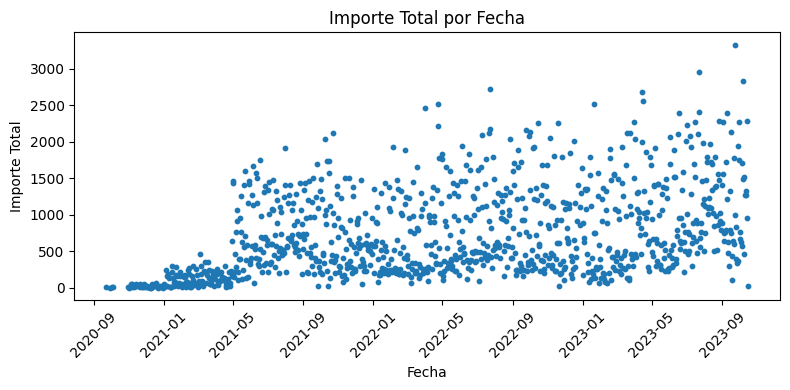

In [10]:
Data1 = data.groupby(['created_at'])['importe'].sum().reset_index()
plt.figure(figsize=(8, 4))
plt.scatter(Data1['created_at'], Data1['importe'], s=10)
plt.xlabel("Fecha")
plt.ylabel('Importe Total')
plt.title('Importe Total por Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

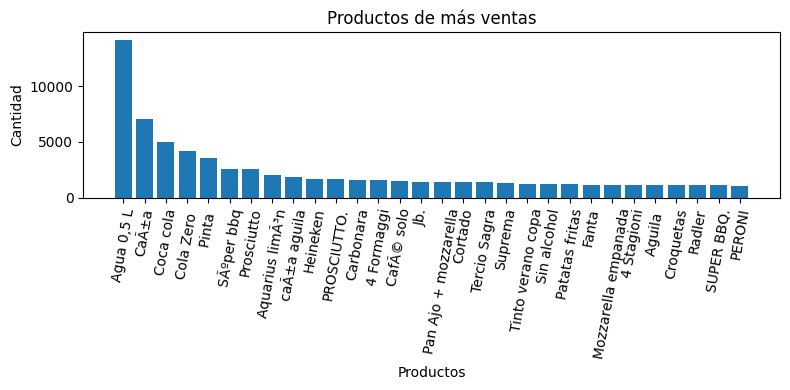

In [13]:
Data1 = data.groupby(["product_name"])['qty'].sum().reset_index()
Data2 = Data1.sort_values(by='qty', ascending=False)
plt.figure(figsize=(8, 4))
plt.bar(Data2['product_name'][:30], Data2['qty'][:30])
plt.xlabel('Productos')
plt.ylabel('Cantidad')
plt.title('Productos de más ventas')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

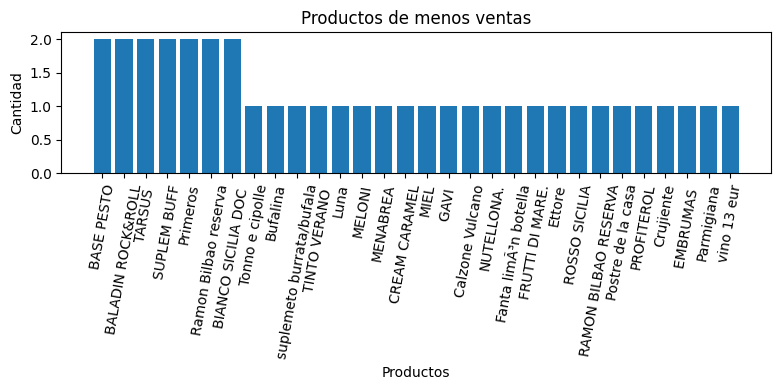

In [15]:
Data3 = Data1.sort_values(by='qty', ascending=False)
plt.figure(figsize=(8, 4))
plt.bar(Data3['product_name'][-30:], Data3['qty'][-30:])
plt.xlabel('Productos')
plt.ylabel('Cantidad')
plt.title('Productos de menos ventas')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100691 entries, 0 to 100690
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   created_at    100691 non-null  object 
 1   updated_at    100691 non-null  object 
 2   id            100691 non-null  int64  
 3   deleted_at    0 non-null       float64
 4   is_active     100691 non-null  int64  
 5   qty           100691 non-null  int64  
 6   product_name  100691 non-null  object 
 7   details       5526 non-null    object 
 8   importe       100691 non-null  float64
 9   qty_payed     100691 non-null  int64  
 10  total_price   100691 non-null  float64
 11  command_id    100691 non-null  int64  
 12  product_id    100691 non-null  int64  
 13  is_deleted    100691 non-null  int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 10.8+ MB


### Transformación de los datos, Entrenamiento del modelo y Validación de los resultados

In [21]:
producto = "Agua 0,5 L"
data['created_at'] = pd.to_datetime(data['created_at']).dt.date
data1 = data.iloc[2001:81669]
data2 = data1[data1['product_name'] == producto]
data3 = data2.groupby('created_at')['qty'].sum().reset_index()
data3.columns = ['ds', 'y']
data4 = data3.sort_values(by='ds')

model = Prophet()
model = Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='year', period=365, fourier_order=1)
model.fit(data4)

start_date = '2023-06-01'
end_date = '2023-10-05'
future = pd.date_range(start=start_date, end=end_date, freq='D')
future = pd.DataFrame({'ds': future})
forecast = model.predict(future)
predictions_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'Fecha', 'yhat': 'Predicción'})
predictions_df['Predicción'] = predictions_df['Predicción'].apply(math.floor)

data5 = data[data['product_name'] == producto]
data6 = data5.groupby('created_at')['qty'].sum().reset_index()
data6['created_at'] = pd.to_datetime(data6['created_at'])

data_main = pd.merge(left=predictions_df, right=data6, how="inner", left_on="Fecha", right_on="created_at")
data_main.drop(columns=['created_at'], inplace=True)
data_main['diferencia'] = (data_main['Predicción'] - data_main['qty']).abs()
y_true = data_main['qty']
y_pred = data_main['Predicción']
mae = round(mean_absolute_error(y_true, y_pred),2)

print("Predicción de ventas por producto")
print("Nombre del Producto:", producto)
print("Error Absoluto Medio (MAE):", mae)
data_main.head(10)

13:53:42 - cmdstanpy - INFO - Chain [1] start processing
13:53:42 - cmdstanpy - INFO - Chain [1] done processing


Predicción de ventas por producto
Nombre del Producto: Agua 0,5 L
Error Absoluto Medio (MAE): 6.2


,Fecha,Predicción,qty,diferencia
0,2023-06-01,11,5,6
1,2023-06-02,27,42,15
2,2023-06-03,38,34,4
3,2023-06-04,24,7,17
4,2023-06-05,11,6,5
5,2023-06-06,12,1,11
6,2023-06-07,11,18,7
7,2023-06-08,13,8,5
8,2023-06-09,29,21,8
9,2023-06-10,40,32,8


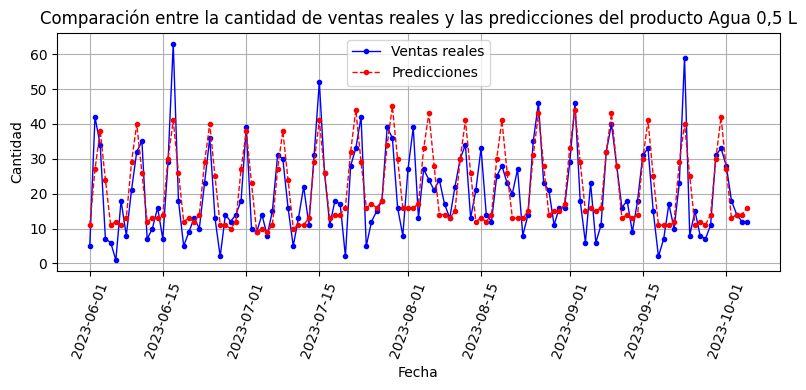

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(data_main['Fecha'], data_main['qty'], label='Ventas reales', color='blue', marker='o', markersize=3,linewidth=1)
plt.plot(data_main['Fecha'], data_main['Predicción'], label='Predicciones', color='red', linestyle='dashed', marker='o', markersize=3,linewidth=1)
plt.title(f'Comparación entre la cantidad de ventas reales y las predicciones del producto {producto}')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.xticks(rotation=70)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()